In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pathlib import Path
import seaborn as sns
import plotly.express as px
import functions as funcs
import pyemma as pm

import matplotlib as mpl

# Load data

In [2]:
all_ts = pd.read_hdf('timescales.h5', key='timescales')
all_vamps = pd.read_hdf('vamps.h5', key='vamps')
all_vamps.rename(columns={'k': 'num_its'}, inplace=True)
chosen_lags = pd.read_hdf('chosen_lag_times.h5', key='chosen_lags')
chosen_dom_procs = pd.read_hdf('chosen_num_dominant.h5', key='chosen_num_dominant')

# Tidy dataframes

We're only interested in VAMP2 scores and the non-hyperparameter columns

In [3]:


def create_feature_dict(df):
    def f(x):
        if x['feature__value'] == 'dihedrals':
            return 'dihed.'
        if x['feature__value'] == 'distances':
            if x['distances__transform'] == 'linear': 
                return 'dist.'
            elif x['distances__transform'] == 'logistic':
                return 'logit(dist.)'
        
    df['feature'] = df.apply(f, axis=1)
    fdict = dict(zip(df['hp_index'].values, df['feature'].values))
    
    return fdict


def subset_columns(df): 
    df = df.loc[:, ['iteration', 'value','protein', 'hp_index', 'lag', 'num_its']]
    return df
    

def subset_method(df, method='VAMP2'):
    df['choose_method'] = method
    return df.loc[df.method==df.choose_method, :].copy()
    
    
vamps = subset_method(all_vamps)

fdict = create_feature_dict(vamps)

ts = subset_columns(all_ts)
vamps = subset_columns(vamps)




#  Calculate ratio

In [4]:
def timescale_ratio(df):

    t = df.loc[:, ['value', 'iteration', 'protein', 'hp_index', 'lag', 'num_its']].copy()
    dupes = t.duplicated(subset=['iteration', 'protein', 'hp_index', 'lag', 'num_its'])
    assert not np.any(dupes.values)

    t['log_value'] = np.log(t['value'])
    t.sort_values(by=['protein','hp_index', 'lag', 'iteration', 'num_its'], inplace=True)
    t['ratio'] = np.exp(t.groupby(['protein', 'hp_index', 'lag', 'iteration']).diff(periods=-1)['log_value'])
    return t

ts_ratio = timescale_ratio(ts)

# Calculate bootstrap summary

In [5]:
def bs_summary(df, score_column='value', subset=['protein', 'hp_index', 'lag', 'num_its']):
    score = df.groupby(subset, as_index=False).agg(
                            median = (score_column, lambda x: np.quantile(x, 0.5)), 
                            lb = (score_column, lambda x: np.quantile(x, 0.025)), 
                            ub = (score_column, lambda x: np.quantile(x, 0.975)))
    score['lb_diff'] = score['median'] - score['lb']
    score['ub_diff'] = score['ub'] - score['median']
    score.drop(labels=['lb', 'ub'], axis=1, inplace=True)
    return score
    

vamps_summary = bs_summary(vamps)
ts_ratio_summary = bs_summary(ts_ratio, score_column='ratio')
ts_summary = bs_summary(ts)

In [6]:
hp_summary = all_vamps.loc[all_vamps.iteration==0, list(all_vamps.filter(regex='__', axis=1).columns) + ['protein', 'protein_dir', 'hp_index']]
hp_summary.drop_duplicates(inplace=True)
hp_summary['feature'] = hp_summary['hp_index'].apply(lambda x: fdict[x])

In [7]:
vamps_summary.to_hdf('./summaries/vamps_bs_summary.h5', key='vamps_summary')
ts_ratio_summary.to_hdf('./summaries/ts_ratio_bs_summary.h5', key='ts_ratio_summary')
ts_summary.to_hdf('./summaries/ts_bs_summary.h5', key='ts_summary')
hp_summary.to_hdf('./summaries/hp_summary.h5', key='hp_summary')

# VAMP-E

We might also want VAMP-E summary so let's do those as well

In [8]:
vampe = subset_method(all_vamps, method='VAMPE')
vampe = subset_columns(vampe)
vampe_summary = bs_summary(vamps)
vampe_summary.to_hdf('./summaries/vampe_bs_summary.h5', key='vampe_summary')


# Figure

In [9]:
df = vamps_summary.merge(ts_ratio_summary, on=['protein', 'hp_index', 'lag', 'num_its'], suffixes=['_vamp', '_gap'])

df['feature'] = df['hp_index'].apply(lambda x: fdict[x])

In [10]:
all_best_models = pd.read_hdf('best_hps_per_feature.h5')
all_best_models.rename(columns={'k':'num_its'}, inplace=True)


Chignolin
Trp-cage
BBA
Villin
WW-domain
BBL
Protein-B
Homeodomain


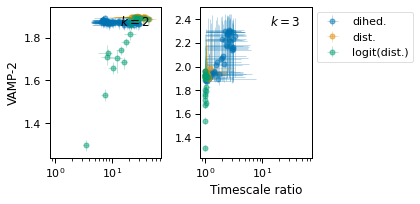

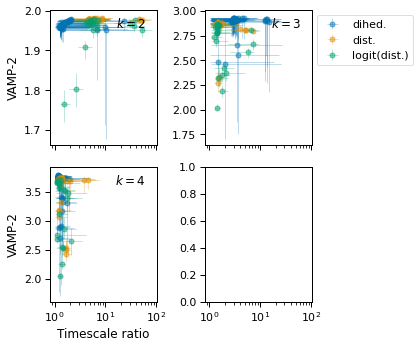

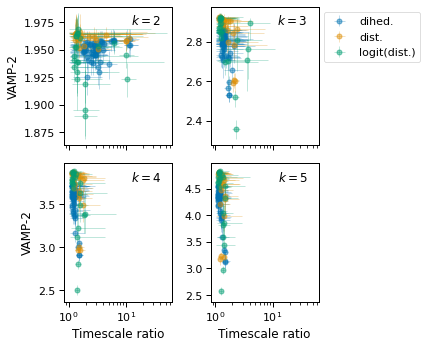

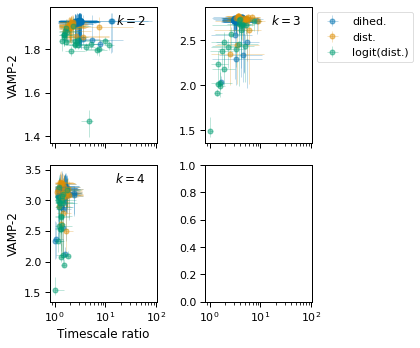

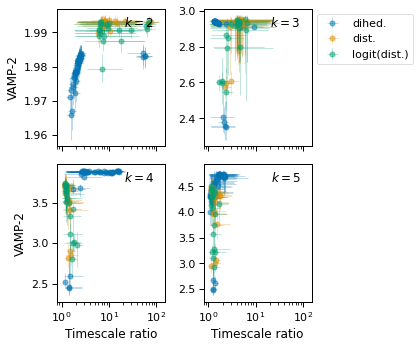

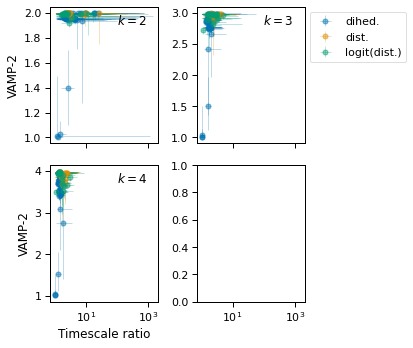

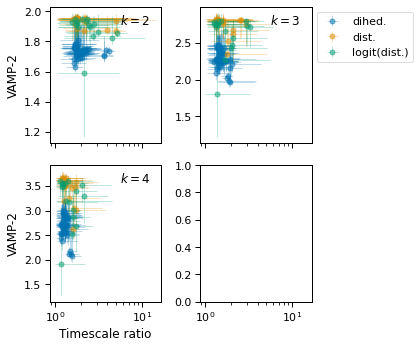

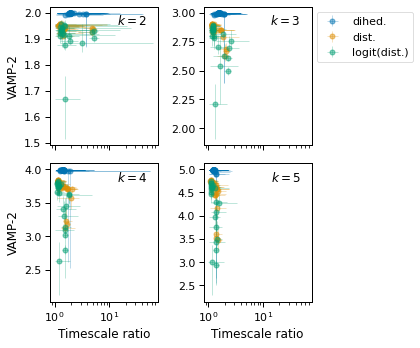

In [11]:
for protein in funcs.PROTEIN_LABELS[:5]+funcs.PROTEIN_LABELS[6:9]:
# protein = 'BBA'
    print(protein)
    max_k = chosen_dom_procs.loc[chosen_dom_procs.protein==protein, 'num_its'].values[0]+1
    lag = chosen_lags.loc[chosen_lags.protein==protein, 'lag'].values[0]


    ks = np.arange(2, max_k+1)
    n_ks = ks.shape[0]
    features = np.unique(df.feature.values)


    best_df = all_best_models.loc[all_best_models.protein==protein, :].copy()
    best_df.sort_values(by='hp_rank', inplace=True)
    best_model_num = dict(zip(np.arange(1, best_df.shape[0]+1), best_df['hp_index']))
    best_markers = ['P','X', 'D', 'o']

    cols = sns.color_palette('colorblind', features.shape[0])

    n_cols = 2
    n_rows = n_ks//n_cols + (n_ks % n_cols)

    with sns.plotting_context('paper', font_scale=1.25):

        fig, axes = plt.subplots(n_rows, n_cols, figsize=(6, 1+2*n_rows), sharey=False, sharex=True)
        if axes.ndim==1:
            axes = axes.reshape(1, -1)
        for i in range(ks.shape[0]):
            ax = axes.flatten()[i]

            for j, feat in enumerate(features):

                ix = (df.protein == protein) & (df.num_its == ks[i] ) & (df.lag == lag) & (df.feature == feat)
                x = df.loc[ix, 'median_gap'].values
                xerr = df.loc[ix, ['lb_diff_gap', 'ub_diff_gap']].values.T

                y = df.loc[ix, 'median_vamp'].values
                yerr = df.loc[ix, ['lb_diff_vamp', 'ub_diff_vamp']].values.T

                ax.errorbar(x, y, xerr=xerr, yerr=yerr, lw=0, elinewidth=0.5, marker='o', color=cols[j], alpha=0.5, label=feat, ms=5)
                ax.set_xscale('log')

    #         for mod_num, hp_ix in best_model_num.items():
    #             best_ix = (df.protein == protein) & (df.num_its == ks[i] ) & (df.lag == lag) & (df.hp_index == hp_ix)
    #             best_x = df.loc[best_ix, 'median_gap'].values
    #             best_y = df.loc[best_ix, 'median_vamp'].values       
    #             best_f = df.loc[best_ix, 'feature'].values[0]
    #     #         ax.annotate(text=f"{mod_num}", xy=(best_x, best_y), xytext=(20, 20), textcoords='offset points',arrowprops=dict(arrowstyle="->",connectionstyle="arc3"),)
    #             ax.scatter(best_x, best_y, marker=best_markers[mod_num-1], alpha=1, s=100, color=cols[np.where(features == best_f)[0][0]], label=f"Model {mod_num}", edgecolor='k', zorder=10)

            if i % n_cols == 0: 
                ax.set_ylabel(f'VAMP-2')

            if i // n_rows == 1: 
                ax.set_xlabel('Timescale ratio')

            ax.annotate(text=f"$k={{{ks[i]}}}$", xy=(0.9, 0.95), ha='right', va='top' , xycoords='axes fraction')


        axes[0, -1].legend(bbox_to_anchor=(1, 1), loc='upper left')
        plt.tight_layout()
        plt.savefig(Path(funcs.FIG_DIR).joinpath(f"{protein}_vamp_vs_gap.pdf"), bbox_inches='tight')
    

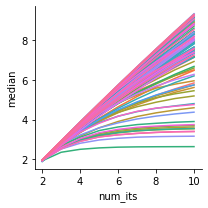

In [12]:
df = vampe_summary.loc[(vampe_summary.lag==40)&(vampe_summary.protein=='BBA'), : ]
g = sns.FacetGrid(data=df, hue='hp_index')
g.map(plt.plot, 'num_its', 'median')